In [1]:
import pandas as pd
import numpy as np
import warnings
import os
warnings.filterwarnings(action='ignore')

import seaborn as sns
sns.set_palette("pastel")
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
os.chdir("../")
root_path = os.getcwd()

# 따옴표 안에 데이터가 있는 폴더의 상위폴더
data_folder_path = os.path.join(root_path, 'data')
original_file_path = os.path.join(data_folder_path, 'original_data')
original_raw_file_path = os.path.join(original_file_path,'raw_data')
original_processed_file_path = os.path.join(original_file_path,'processed_data')

external_file_path = os.path.join(data_folder_path,'external_data')
external_raw_file_path = os.path.join(external_file_path,'raw_data')
external_processed_file_path = os.path.join(external_file_path,'processed_data')

SNS에서 보였던 업종에 대한 긍정적인 인식이 실제 택배 주문에도 영향을 미칠까?<br>
SNS 데이터의 업종별 긍정 언급 횟수와 물류 데이터의 송장 건수와의 상관관계를 비교해 보겠다.<br>
<br>
**물류=>SNS**
* 도서/ 음반 => 문화취미
* 스포츠/레저 => 레저업소
* 식품 => 요식업소(억지일수도...)
* 화장품/미용(세부분류 중에 화장품, 마사지 뿐만 아니라 마스크, 소독제 등이 포함되기 때문) => 보건위생

# Data Preprocessing

In [ ]:
mul = pd.read_excel(os.path.join(original_raw_file_path,'05_물류데이터(CJ올리브네트웍스)','2020 빅콘테스트_CJ올리브네트웍스_제공DB.xlsx'))
data = pd.read_csv(os.path.join(original_raw_file_path,'03_SNS데이터(와이즈넛)','2020 bigcontest data_wisenut.csv'),sep='')

In [ ]:
data = data.rename(columns =  {'GU_NM(삭제)':'GU_NM', 'DONG_NM(삭제)':'DONG_NM'})
data['CTGG_CD'] = data['GU_CD'].astype('str').str[:2].astype('int64')
data['HDNG_CD'] = data['DONG_CD']
data['CGDG_CD'] = data['CTGG_CD'].astype('str')+data['HDNG_CD'].astype('str')

In [ ]:
mul['DL_YM'] = mul['DL_YMD'].astype('str').str[:4].astype('int64')
mul['CGDG_CD'] = mul['CTGG_CD'].astype('str')+mul['HDNG_CD'].astype('str')

mul['YEAR'] = '20'+mul['DL_YM'].astype('str').str[:2]
mul['MONTH'] = mul['DL_YM'].astype('str').str[-2:]

In [ ]:
# SNS의 업종과 매칭되는 물류 카테고리 설정 및 groupby

mul_f1 = mul.query('(DL_GD_LCLS_CD == 12) or (DL_GD_LCLS_CD == 16) or (DL_GD_LCLS_CD == 17) or (DL_GD_LCLS_CD == 21)')

up_dl = mul_f1.groupby(['YEAR','MONTH','DL_GD_LCLS_NM'])['INVC_CONT'].sum().reset_index() #지역정보 미포함
up_dl_gd = mul_f1.groupby(['YEAR','MONTH','DL_GD_LCLS_NM','CGDG_CD'])['INVC_CONT'].sum().reset_index() #지역정보 포함

In [ ]:
data.drop(columns=['SEQ','HDNG_CD','HDNG_CD','CTGG_CD','GU_CD','DONG_CD'],inplace=True)

In [ ]:
df = pd.melt(data,id_vars=['CGDG_CD','GU_NM','DONG_NM'],var_name='CAT',value_name='CNT')

In [ ]:
df['MONTH'] = df['CAT'].str[-2:].astype('int64')
df['YEAR'] = df['CAT'].str[-6:-2].astype('int64')
df['CAT'] = df['CAT'].str[:-7]

In [ ]:
df['GU_DONG'] = df[['GU_NM', 'DONG_NM']].apply(lambda x: ','.join(x), axis=1)

In [ ]:
# sns 업종 labeling
f = df[df['CAT'].str.contains('TIVE')]
f['UP'] = f['CAT'].str[:3]
f['SENTIMENT'] = f['CAT'].str[-8:-5]

f.loc[f['UP'] == 'UP1', 'UP'] = '숙박'
f.loc[f['UP'] == 'UP2', 'UP'] = '레저'
f.loc[f['UP'] == 'UP3', 'UP'] = '문화취미'
f.loc[f['UP'] == 'UP4', 'UP'] = '의료기관'
f.loc[f['UP'] == 'UP5', 'UP'] = '보건위생'
f.loc[f['UP'] == 'UP6', 'UP'] = '요식업'

In [ ]:
up_dl_gd['MONTH'] = up_dl_gd['MONTH'].astype('int64')
up_dl_gd['YEAR'] = up_dl_gd['YEAR'].astype('int64')

# 행정동 별 SNS 언급과 물류 송장건수 Count

In [ ]:
up_cnt = f.query('SENTIMENT == "POS"').groupby(['YEAR','MONTH','GU_DONG','CGDG_CD','UP'])['CNT'].sum().reset_index()

In [ ]:
a = pd.pivot_table(up_cnt,index=['YEAR','MONTH','CGDG_CD','GU_DONG'],columns='UP',values='CNT').reset_index() #sns 언급 데이터 pivot table
b = pd.pivot_table(up_dl_gd, index=['YEAR','MONTH','CGDG_CD'],columns='DL_GD_LCLS_NM',values='INVC_CONT').reset_index() #물류 데이터 pivot table
b = pd.merge(b,a[['CGDG_CD','GU_DONG']],on='CGDG_CD')

In [ ]:
a

In [24]:
a

UP,YEAR,MONTH,CGDG_CD,GU_DONG,레저,문화취미,보건위생,숙박,요식업,의료기관
0,2019,2,11517,"대구 중구,동인동",0,24,38,0,20,14
1,2019,2,11545,"대구 중구,삼덕동",0,2,38,26,43,6
2,2019,2,11565,"대구 중구,성내동",0,3,0,19,0,0
3,2019,2,11595,"대구 중구,대신동",0,3,0,19,0,0
4,2019,2,11640,"대구 중구,남산동",0,73,0,19,14,147
...,...,...,...,...,...,...,...,...,...,...
275,2020,5,35560,"서울 노원구,월계동",0,296,386,3,85,205
276,2020,5,35595,"서울 노원구,공릉동",2,437,908,235,242,4301
277,2020,5,35611,"서울 노원구,하계동",0,213,938,138,17,4426
278,2020,5,35619,"서울 노원구,중계동",0,718,396,0,79,436


In [25]:
b

,YEAR,MONTH,CGDG_CD,도서/음반,스포츠/레저,식품,화장품/미용,GU_DONG
0,2019,2,11517,1487,227,4169,2695,"대구 중구,동인동"
1,2019,2,11517,1487,227,4169,2695,"대구 중구,동인동"
2,2019,2,11517,1487,227,4169,2695,"대구 중구,동인동"
3,2019,2,11517,1487,227,4169,2695,"대구 중구,동인동"
4,2019,2,11517,1487,227,4169,2695,"대구 중구,동인동"
...,...,...,...,...,...,...,...,...
2235,2020,5,35630,3134,893,16973,8078,"서울 노원구,상계동"
2236,2020,5,35630,3134,893,16973,8078,"서울 노원구,상계동"
2237,2020,5,35630,3134,893,16973,8078,"서울 노원구,상계동"
2238,2020,5,35630,3134,893,16973,8078,"서울 노원구,상계동"


# SNS 데이터와 송장 건수 간 상관관계 Heatmap

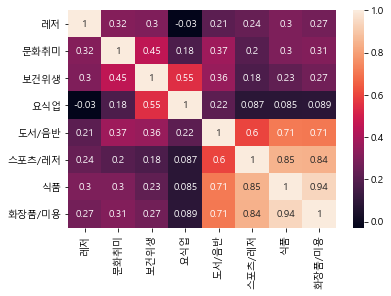

In [32]:
# 2019년 SNS 업종 긍정 언급량과 물류 배송 횟수 간의 상관관계 => 별 관련성이 없음
c = pd.merge(a,b,how='inner',on=['CGDG_CD','YEAR','MONTH']).query('YEAR == 2019').drop(columns=['YEAR','MONTH','숙박','의료기관'])
sns.heatmap(c.corr(),annot=True)

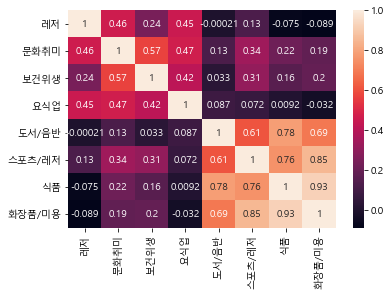

In [33]:
# 2020년 SNS 업종 긍정 언급량과 물류 배송 횟수 간의 상관관계 => 별 관련성이 없음
d = pd.merge(a,b,how='inner',on=['CGDG_CD','YEAR','MONTH']).query('YEAR == 2020').drop(columns=['YEAR','MONTH','숙박','의료기관'])
sns.heatmap(d.corr(),annot=True)

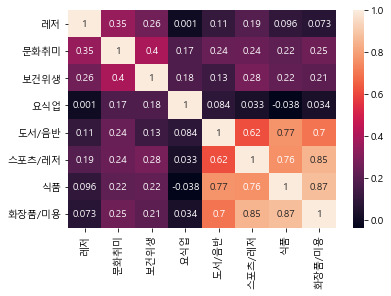

In [34]:
# 전체 기간 동안 SNS 업종 긍정 언급량과 물류 배송 횟수 간의 상관관계 => 별 관련성이 없음
e = pd.merge(a,b,how='inner',on=['CGDG_CD','YEAR','MONTH']).drop(columns=['YEAR','MONTH','숙박','의료기관'])
sns.heatmap(e.corr(),annot=True)